# Inventory Optimization Using (s, Q) and (R, S) Policies

In this notebook, we provide a framework for evaluating inventory management policies such as (s, Q) and (R, S) using a single-echelon supply chain simulator.

In [302]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-white')
import pandas as pd
from matplotlib import rc, cm
plt.rcParams.update({'pdf.fonttype': 'truetype'})

# Simulator

We start with implementing a simulator of a traditional supply chain environment. We use it to analyze various scenarious in the next sections.

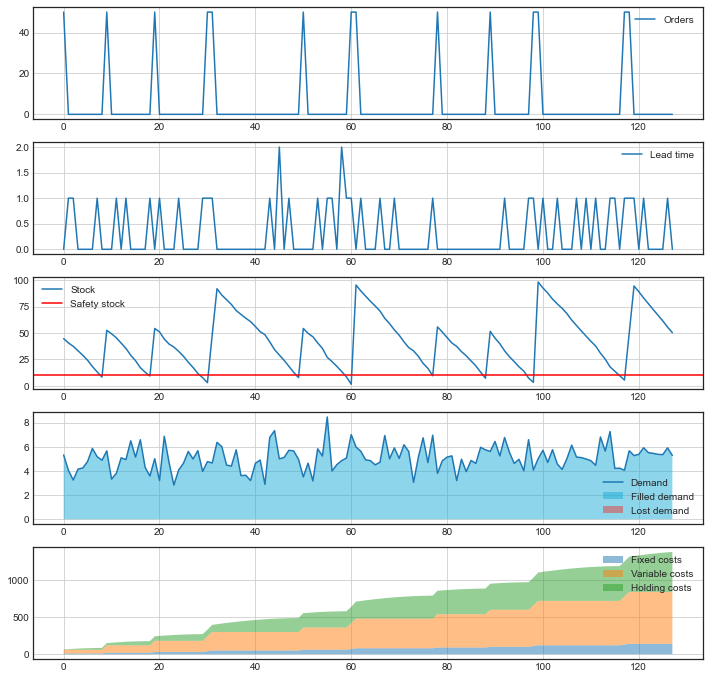

In [381]:
#
# Random generators
#
class Generator:
    def next(self):
        pass
    
class ConstantGenerator(Generator):
    def __init__(self, mu):
        self.mu = mu
    
    def next(self):
        return self.mu
    
class NormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def next(self):
        return np.random.normal(self.mu, self.sigma, 1)[0]
    
class HalfNormalGenerator(Generator):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
    
    def next(self):
        return abs(np.random.normal(self.mu, self.sigma, 1)[0])

#
# Inventory policies
#
class InventoryPolicy:
    def get_order_quantity(self, supply_chain):
        pass
    
class ConstantInventoryPolicy(InventoryPolicy):
    def __init__(self, q):
        self.q = q
    
    def get_order_quantity(self, supply_chain):
        return q
    
class sQInventoryPolicy(InventoryPolicy):
    def __init__(self, s, Q):
        self.s = s
        self.Q = Q
    
    def __str__(self):
        return f'(s={self.s}, Q={self.Q}'
    
    def get_order_quantity(self, supply_chain):
        net_inventory = supply_chain.get_stock() + supply_chain.get_intransit()
        if net_inventory <= self.s:
            return self.Q
        else:
            return 0
        
class RSInventoryPolicy(InventoryPolicy):
    def __init__(self, R, S):
        self.S = S
        self.R = R
    
    def __str__(self):
        return f'(R={self.R}, S={self.S}'
    
    def get_order_quantity(self, supply_chain):
        net_inventory = supply_chain.get_stock() + supply_chain.get_intransit()
        if supply_chain.t % self.R == 0 and net_inventory <= self.S:
            return self.S - net_inventory
        else:
            return 0

#
# Supply chain simulator
#
class SupplyChain:
    
    def __init__(self, config):
        self.orders = []
        self.stock = []
        self.demand = []
        self.lead_times = []
        self.t = 0
        
        self.fixed_tx_cost = config['fixed_transaction_cost']
        self.variable_tx_cost = config['variable_transaction_cost']
        self.holding_cost = config['holding_cost']
        self.demand_generator = config['demand_generator']
        self.lead_time_generator  = config['lead_time_generator']
        self.policy = config['policy']
        
        # auxiliary variables for effeciency calculations
        self._filled_demand = []
        self._fixed_tx_costs = []
        self._variable_tx_costs = []
        self._holding_costs = []
    
    def get_stock(self):
        if not self.stock:
            return 0
        else:
            return self.stock[-1]
        
    def get_intransit(self):
        in_transit = 0
        for i in range(self.t):
            if self.t < i + self.lead_times[i]:
                in_transit += self.orders[i] 
        return in_transit
    
    def process_demand(self):
        demand = self.demand_generator.next()
        self.demand.append(demand)
        
        filled_demand = min(demand, self.stock[self.t])
        self.stock[self.t] -= filled_demand
        
        self._filled_demand.append(filled_demand)
        
    def place_order(self):
        order = self.policy.get_order_quantity(self) 
        self.orders.append(order)
        
        lead_time = int(self.lead_time_generator.next())
        self.lead_times.append(lead_time)
    
    def procees_orders(self):
        new_stock = 0
        for i in range(self.t + 1):
            if self.t == i + self.lead_times[i]:
                new_stock += self.orders[i]
                
        self.stock.append(self.get_stock() + new_stock)
        
    def update_costs(self):
        if self.orders[self.t] != 0:
            self._fixed_tx_costs.append(self.fixed_tx_cost)
            self._variable_tx_costs.append(self.orders[self.t] * self.variable_tx_cost)
        else:
            self._fixed_tx_costs.append(0)
            self._variable_tx_costs.append(0)
        self._holding_costs.append(self.stock[self.t] * self.holding_cost)
    
    def act(self):    
        
        self.place_order()
        self.procees_orders()
        self.process_demand()
        
        self.update_costs()
        
        self.t += 1
    
        
def plot_supply_chain(supply_chain):
    fig, ax = plt.subplots(5, 1, figsize=(12, 12))
    x = np.arange(supply_chain.t)
    ax[0].plot(x, supply_chain.orders, label='Orders')
    ax[1].plot(x, supply_chain.lead_times, label='Lead time')
    
    ax[2].plot(x, supply_chain.stock, label='Stock')
    if isinstance(supply_chain.policy, sQInventoryPolicy):  
        ax[2].axhline(supply_chain.policy.s, color='red', label='Safety stock')
    if isinstance(supply_chain.policy, RSInventoryPolicy):  
        ax[2].axhline(supply_chain.policy.S, color='red', label='Up-to level')
    
    ax[3].plot(x, supply_chain.demand, label='Demand')
    ax[3].fill_between(x, np.zeros(len(x)), supply_chain._filled_demand, facecolor="#1DACD6", alpha=.5, label='Filled demand')
    ax[3].fill_between(x, supply_chain._filled_demand, supply_chain.demand, facecolor="#CC6666", alpha=.7, label='Lost demand')
    
    fc = np.cumsum(supply_chain._fixed_tx_costs)
    vc = np.cumsum(supply_chain._variable_tx_costs)
    hc = np.cumsum(supply_chain._holding_costs)
    ax[4].fill_between(x, np.zeros(len(x)), fc, alpha=0.5, label='Fixed costs')
    ax[4].fill_between(x, fc, fc + vc, alpha=0.5, label='Variable costs')
    ax[4].fill_between(x, fc + vc, fc + vc + hc, alpha=0.5, label='Holding costs')
    
    for axi in ax:
        axi.grid(True)
        axi.legend()

##########################################################################

config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.1,
    'demand_generator': HalfNormalGenerator(5, 1),
    'lead_time_generator': HalfNormalGenerator(0, 1),
    'policy': sQInventoryPolicy(10, 50)
}

simulator = SupplyChain(config)
for t in range(128):
    simulator.act()

plot_supply_chain(simulator)

In [454]:
#
# Helper functions for performance metrics calculation based on the simulation traces
#
def get_holding_costs(supply_chain):
    return np.sum(supply_chain._holding_costs)
    
def get_fixed_transaction_costs(supply_chain):
    return np.sum(supply_chain._fixed_tx_costs)

def get_fill_rate(supply_chain):
    return 1 - np.sum(np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)) / np.sum(supply_chain.demand)

def get_cycle_service_level(supply_chain):
    n_cycles, n_stock_outs = 0, 0
    is_stock_out = False
    lost_demand = np.array(supply_chain.demand) - np.array(supply_chain._filled_demand)
    for t in range(supply_chain.t):
        if supply_chain.orders[t] != 0 or t == supply_chain.t - 1:
            n_cycles += 1
            if is_stock_out:
                n_stock_outs += 1
            is_stock_out = False
            
        if lost_demand[t] != 0:
            is_stock_out = True
            
    return n_cycles, n_stock_outs, 1 - n_stock_outs/n_cycles

# Scenario 1: Find Cost-Optimal Order Quantity for (s,Q) policy

We first analyze how order quantity Q in (s,Q) policy impacts the supply chain costs, and how the optimal value can be determined.

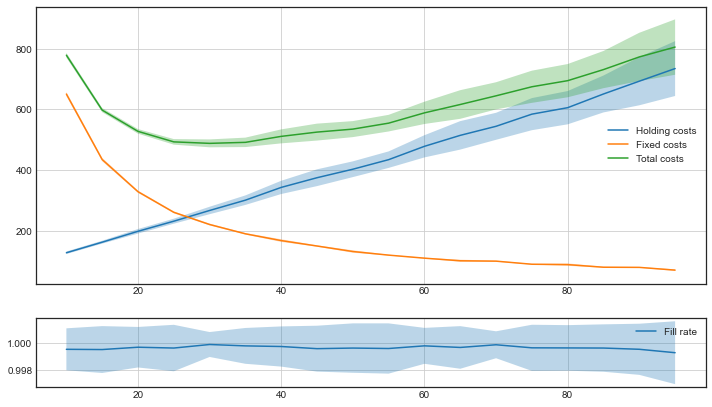

In [474]:
#
# This function performs multiple simulations 
# for a 1D array of configurations 
#
def evaluate_scenarios(n_simulations, n_sim_steps, parameter_grid, config_grid):
    trace_dims = (len(config_grid), n_simulations)
    
    holding_costs = np.zeros(trace_dims)
    fixed_costs = np.zeros(trace_dims)
    total_costs = np.zeros(trace_dims)
    
    fill_rates = np.zeros(trace_dims)
    service_levels = np.zeros(trace_dims)
    
    for i, config in enumerate(config_grid):
        for j in range(n_simulations):
            simulator = SupplyChain(config)
            for t in range(n_sim_steps):
                simulator.act()
        
            holding_costs[i][j] = get_holding_costs(simulator)
            fixed_costs[i][j] = get_fixed_transaction_costs(simulator)
            total_costs[i][j] = holding_costs[i][j] + fixed_costs[i][j]
            fill_rates[i][j] = get_fill_rate(simulator)
            service_levels[i][j] = get_cycle_service_level(simulator)[-1]

    holding_cost_summary = np.vstack([np.mean(holding_costs, axis=1), np.std(holding_costs, axis=1)])
    fixed_cost_summary = np.vstack([np.mean(fixed_costs, axis=1), np.std(fixed_costs, axis=1)])
    total_cost_summary = np.vstack([np.mean(total_costs, axis=1), np.std(total_costs, axis=1)])
    fill_rate_summary = np.vstack([np.mean(fill_rates, axis=1), np.std(fill_rates, axis=1)])
    service_levels_summary = np.vstack([np.mean(service_levels, axis=1), np.std(service_levels, axis=1)])
    
    return {'holding_costs': holding_cost_summary, 
            'fixed_costs': fixed_cost_summary, 
            'total_costs': total_cost_summary,
            'fill_rates': fill_rate_summary, 
            'service_levels': service_levels_summary}

#
# This funtion visulizes the dependency between the simulation parameters
# and supply chain costs/SLAs 
#
def plot_costs(parameter_grid, evaluation_results, mode):
    x = parameter_grid
    
    if mode == 'costs':
        metrics = [(evaluation_results['holding_costs'], 'Holding costs', 0), (evaluation_results['fixed_costs'], 'Fixed costs', 0), 
               (evaluation_results['total_costs'], 'Total costs', 0), (evaluation_results['fill_rates'], 'Fill rate', 1)]
        fig, ax = plt.subplots(2, 1, figsize=(12, 7), gridspec_kw={'height_ratios': [4, 1]})
        for metric in metrics:
            plot_id = metric[2]
            ax[plot_id].plot(x, metric[0][0, :], label = metric[1])
            ax[plot_id].fill_between(x, metric[0][0, :] - metric[0][1, :], metric[0][0, :] + metric[0][1, :], alpha = 0.3)
            ax[plot_id].grid(True)
            ax[plot_id].legend()
            
    if mode == 'service_levels':
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        metric = evaluation_results['service_levels']
        ax.plot(x, metric[0, :], label = 'Service level')
        ax.fill_between(x, metric[0, :] - metric[1, :], metric[0, :] + metric[1, :], alpha = 0.3)
        ax.grid(True)
        ax.legend()
        
#####################################################################################################
        
n_simulations = 64
parameter_grid = np.arange(10, 100, 5) 
config_grid = [ 
    {
        'fixed_transaction_cost': 10,
        'variable_transaction_cost': 1,
        'holding_cost': 0.1,
        'demand_generator': HalfNormalGenerator(5, 0.5),
        'lead_time_generator': HalfNormalGenerator(0, 0.5),
        'policy': sQInventoryPolicy(10, order_quantity)
    }
    for order_quantity in parameter_grid ] 
    
evaluation_results = evaluate_scenarios(n_simulations, 128, parameter_grid, config_grid)
plot_costs(parameter_grid, evaluation_results, mode='costs') 

# Scenario 2: Find Cost-Optimal Review Period R in (R,S) policy

The second scenario we consider is the optimization of the review period of the (R,S) policy. We perform the analysis in three steps:
* First, we do a test simulation to make sure that the set of parameters we have chosen is reasonable.
* Second, we analyze the dependency between the review period and costs.
* Third, we analyze the three-way dependency between review period, up-to level, and costs.

Fill rate = 0.9092864117055546


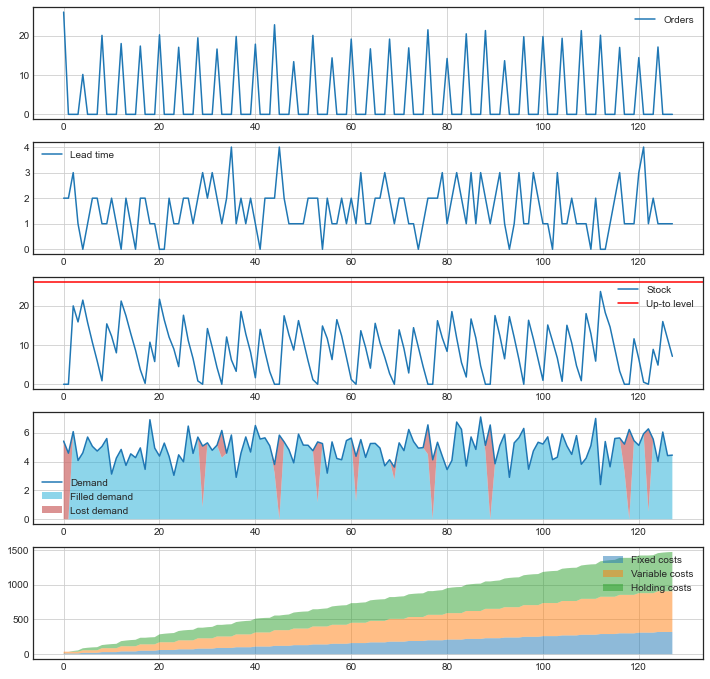

In [438]:
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.5,
    'demand_generator': HalfNormalGenerator(5, 1),
    'lead_time_generator': HalfNormalGenerator(2, 1),
    'policy': RSInventoryPolicy(4, 26)
}

simulator = SupplyChain(config)
for t in range(128):
    simulator.act()

plot_supply_chain(simulator)
print( f'Fill rate = {get_fill_rate(simulator)}' )

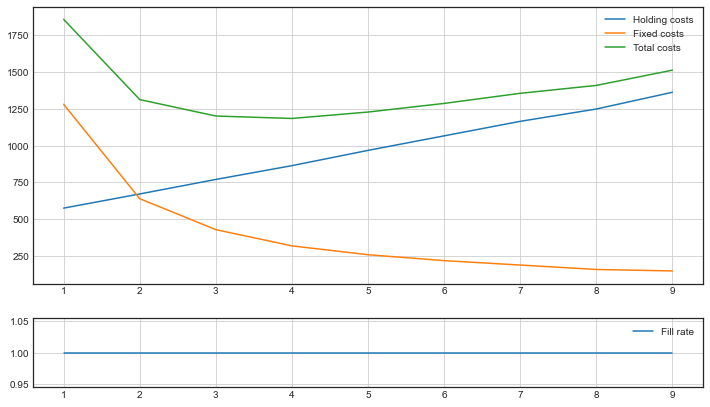

In [475]:
n_simulations = 64
parameter_grid = np.arange(1, 10, 1) 
config_grid = [ 
    {
        'fixed_transaction_cost': 10,
        'variable_transaction_cost': 1,
        'holding_cost': 0.5,
        'demand_generator': HalfNormalGenerator(5, 0.0),
        'lead_time_generator': HalfNormalGenerator(0, 0.0),
        'policy': RSInventoryPolicy(review_period,  10 + 4 * review_period)
    }
    for review_period in parameter_grid ] 


evaluation_results = evaluate_scenarios(n_simulations, 128, parameter_grid, config_grid)
plot_costs(parameter_grid, evaluation_results, mode = 'costs') 

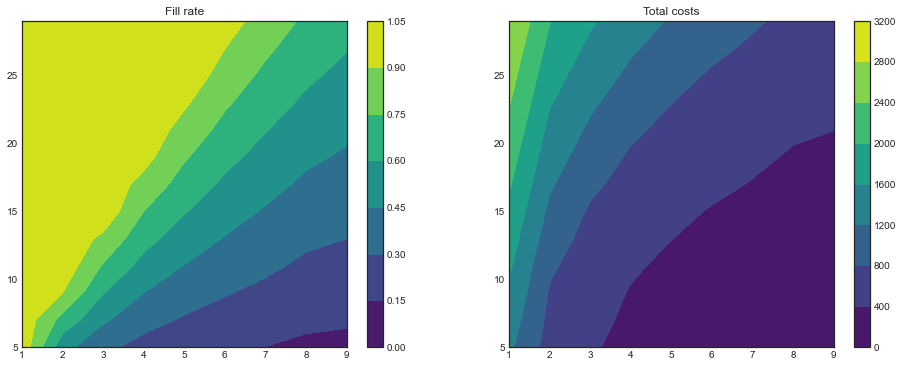

In [490]:
#
# This function performs multiple simulations for a 2D array of configurations
#
def evaluate_scenarios_2d(n_simulations, n_sim_steps, parameter_grid1, parameter_grid2, config_grid):
    trace_dims = (config_grid.shape[0], config_grid.shape[1], n_simulations)
    total_costs = np.zeros(trace_dims)
    fill_rates = np.zeros(trace_dims)
    service_levels = np.zeros(trace_dims)
    
    for i, config_row in enumerate(config_grid):
        for j, config in enumerate(config_row):
            for k in range(n_simulations):
                simulator = SupplyChain(config)
                for t in range(128):
                    simulator.act()
        
                holding_costs = get_holding_costs(simulator)
                fixed_costs = get_fixed_transaction_costs(simulator)
                fill_rates[i][j][k] = get_fill_rate(simulator)
                total_costs[i][j][k] = holding_costs + fixed_costs
                service_levels[i][j][k] = get_cycle_service_level(simulator)[-1]
                
    total_cost_summary = np.mean(total_costs, axis=2)
    fill_rate_summary = np.mean(fill_rates, axis=2)
    service_level_summary = np.mean(service_levels, axis=2)
    
    return {'total_costs': total_cost_summary, 
            'fill_rates': fill_rate_summary, 
            'service_levels': service_level_summary}

#
# This function visulizes the dependency between 
# the simulation parameters and supply chain costs/SLAs 
#
def plot_performance_2d(evaluation_results, parameter_grid1, parameter_grid2, metrics, levels=None):
    fig, ax = plt.subplots(1, len(metrics), figsize=(16, 6))
    x, y = np.meshgrid(parameter_grid1, parameter_grid2)
    
    metrics_spec = []
    if 'fill_rates' in metrics: 
        metrics_spec.append((evaluation_results['fill_rates'], 'Fill rate'))
    if 'total_costs' in metrics: 
        metrics_spec.append((evaluation_results['total_costs'], 'Total costs'))
    if 'service_levels' in metrics: 
        metrics_spec.append((evaluation_results['service_levels'], 'Service level'))
    
    i = 0
    for metric, metric_name in metrics_spec:
            cs = ax[i].contourf(x, y, metric.T, cmap='viridis', levels=levels)
            fig.colorbar(cs, ax=ax[i])
            ax[i].set_title(metric_name)
            i += 1

#########################################################################################
            
n_simulations = 64
parameter_grid1 = np.arange(1, 10, 1)
parameter_grid2 = np.arange(5, 30, 2)
config_grid = np.empty((len(parameter_grid1), len(parameter_grid2)), dtype=object)

for i, review_period in enumerate(parameter_grid1):
    for j, up_to_level in enumerate(parameter_grid2):
        config_grid[i][j] = {
            'fixed_transaction_cost': 10,
            'variable_transaction_cost': 1,
            'holding_cost': 0.5,
            'demand_generator': HalfNormalGenerator(5, 0),
            'lead_time_generator': HalfNormalGenerator(0, 0),
            'policy': RSInventoryPolicy(review_period,  up_to_level)
        }

evaluation_results = evaluate_scenarios_2d(n_simulations, 128, parameter_grid1, parameter_grid2, config_grid)
plot_performance_2d(evaluation_results, parameter_grid1, parameter_grid2, ['fill_rates', 'total_costs'])

# Scenario 3: Analyze the Dependency Between the Demand Variance, Safety Stock, and Service Level

We next analyze the dependecy between the demand variance, safety stock, and service level in the (s,Q) policy:
* First, we do a test simulation to make sure that we have schosen a reasonable set of parameters.
* Second, we analyze the dependency between the safety stock level and cycle service level.
* Third, we analyze the three-way dependency between the demand variance, safety stock, and service level.

Fill rate = 1.0
Cycle servce level = (132, 0, 1.0)


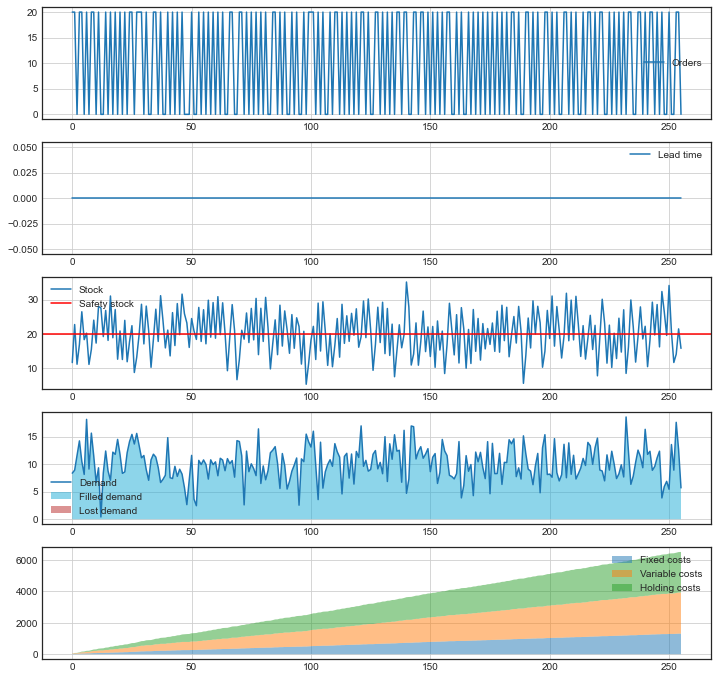

In [460]:
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.5,
    'demand_generator': HalfNormalGenerator(10, 3.0),
    'lead_time_generator': HalfNormalGenerator(0, 0.0),
    'policy': sQInventoryPolicy(20, 20)
}

simulator = SupplyChain(config)
for t in range(256):
    simulator.act()

plot_supply_chain(simulator)
print( f'Fill rate = {get_fill_rate(simulator)}' )
print( f'Cycle servce level = {get_cycle_service_level(simulator)}' )

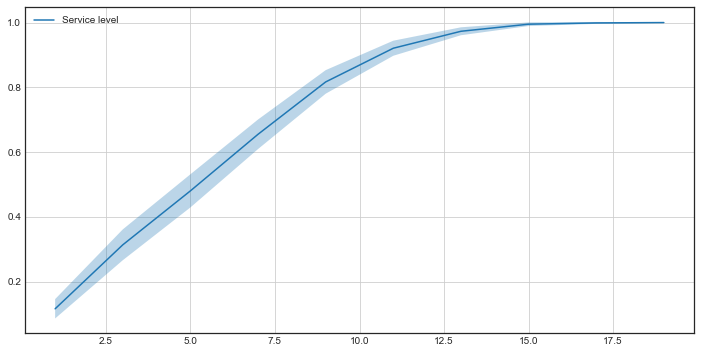

In [482]:
n_simulations = 128
parameter_grid = np.arange(1, 20, 2) 
config_grid = [ 
    {
        'fixed_transaction_cost': 10,
        'variable_transaction_cost': 1,
        'holding_cost': 0.5,
        'demand_generator': HalfNormalGenerator(10, 3.0),
        'lead_time_generator': HalfNormalGenerator(0, 0.0),
        'policy': sQInventoryPolicy(safety_stock,  20)
    }
    for safety_stock in parameter_grid ] 
    
evaluation_results = evaluate_scenarios(n_simulations, 256, parameter_grid, config_grid)
plot_costs(parameter_grid, evaluation_results, mode = 'service_levels') 

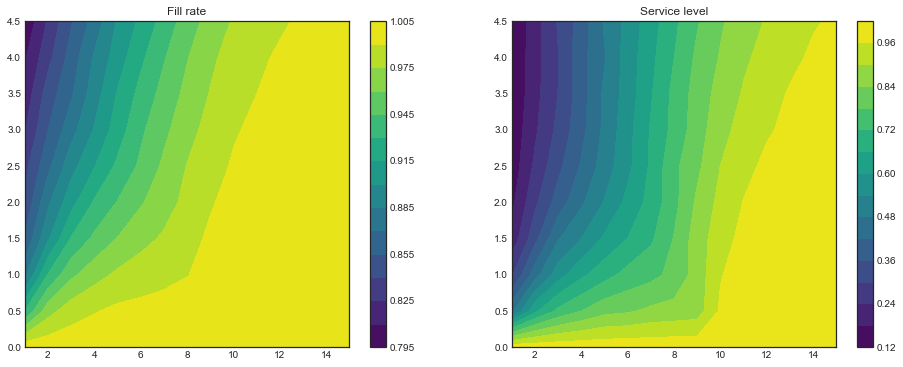

In [491]:
n_simulations = 128
parameter_grid1 = np.arange(1, 16, 1) # safety stock
parameter_grid2 = np.arange(0, 5, 0.5) # demand variance
config_grid = np.empty((len(parameter_grid1), len(parameter_grid2)), dtype=object)

for i, safety_stock in enumerate(parameter_grid1):
    for j, demand_variance in enumerate(parameter_grid2):
        config_grid[i][j] = {
            'fixed_transaction_cost': 10,
            'variable_transaction_cost': 1,
            'holding_cost': 0.5,
            'demand_generator': HalfNormalGenerator(10, demand_variance),
            'lead_time_generator': HalfNormalGenerator(0, 0),
            'policy': sQInventoryPolicy(safety_stock,  20)
        }

evaluation_results = evaluate_scenarios_2d(n_simulations, 512, parameter_grid1, parameter_grid2, config_grid)
plot_performance_2d(evaluation_results, parameter_grid1, parameter_grid2, ['service_levels', 'fill_rates'], levels=16)

# Scenario 4: Analyze the Dependency Between the Lead Time Variance, Safety Stock, and Service Level

Fill rate = 0.7640070356645365
Cycle servce level = (50, 19, 0.62)


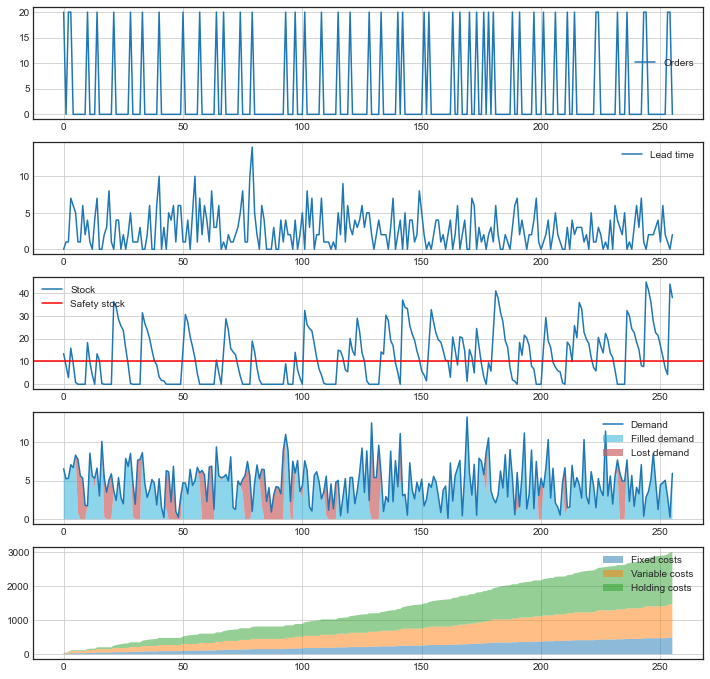

In [507]:
config = {
    'fixed_transaction_cost': 10,
    'variable_transaction_cost': 1,
    'holding_cost': 0.5,
    'demand_generator': HalfNormalGenerator(5, 3.0),
    'lead_time_generator': HalfNormalGenerator(0, 4.0),
    'policy': sQInventoryPolicy(10, 20)
}

simulator = SupplyChain(config)
for t in range(256):
    simulator.act()

plot_supply_chain(simulator)
print( f'Fill rate = {get_fill_rate(simulator)}' )
print( f'Cycle servce level = {get_cycle_service_level(simulator)}' )

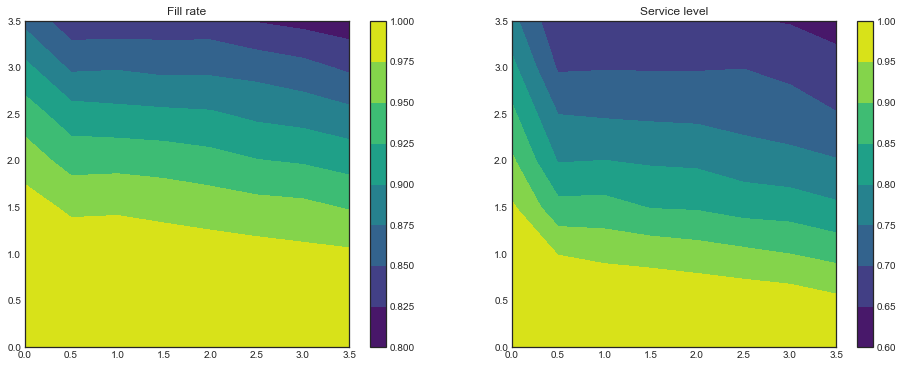

In [510]:
n_simulations = 256
parameter_grid1 = np.arange(0, 4, 0.5) # demand variance
parameter_grid2 = np.arange(0, 4, 0.5) # lead time variance
config_grid = np.empty((len(parameter_grid1), len(parameter_grid2)), dtype=object)

for i, demand_variance in enumerate(parameter_grid1):
    for j, lead_time_variance in enumerate(parameter_grid2):
        config_grid[i][j] = {
            'fixed_transaction_cost': 10,
            'variable_transaction_cost': 1,
            'holding_cost': 0.5,
            'demand_generator': HalfNormalGenerator(5, demand_variance),
            'lead_time_generator': HalfNormalGenerator(0, lead_time_variance),
            'policy': sQInventoryPolicy(10,  20)
        }

evaluation_results = evaluate_scenarios_2d(n_simulations, 1024, parameter_grid1, parameter_grid2, config_grid)
plot_performance_2d(evaluation_results, parameter_grid1, parameter_grid2, ['service_levels', 'fill_rates'], levels=8)